# HMS Brain Activity Classification 

### CELL 1: SETUP

In [1]:
import os
from pathlib import Path
import random
import time
import math
import gc
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.models as models

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix

print("[SETUP] Loading libraries... ✓")

# Device
print("\n[DEVICE] Checking GPU...")
print(f"  CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda:0")
    torch.cuda.empty_cache()
    print("  Using: GPU ✓")
else:
    device = torch.device("cpu")
    print("  Using: CPU")

# Reproducibility
print("\n[SEED] Setting random seeds...")
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)
print("  Random seed: 42 ✓")

# Paths
print("\n[PATHS] Checking data directories...")
DATA_PKG = Path("data_package")
SPEC_DIR = Path("spec_hr_out")

assert DATA_PKG.exists(), "❌ data_package/ not found"
assert SPEC_DIR.exists(), "❌ spec_hr_out/ not found"
print(f"  {DATA_PKG} ✓")
print(f"  {SPEC_DIR} ✓")

print("\n" + "="*60)
print("SETUP COMPLETE ✓")
print("="*60)

[SETUP] Loading libraries... ✓

[DEVICE] Checking GPU...
  CUDA available: True
  GPU: NVIDIA GeForce RTX 5060 Ti
  Using: GPU ✓

[SEED] Setting random seeds...
  Random seed: 42 ✓

[PATHS] Checking data directories...
  data_package ✓
  spec_hr_out ✓

SETUP COMPLETE ✓


### CELL 2:Data Loading

In [2]:
print("[DATA] Loading metadata and labels...\n")

meta_use = pd.read_csv(DATA_PKG / "meta_use.csv")
print(f"  Meta: {meta_use.shape}")

lbl = np.load(DATA_PKG / "labels.npz", allow_pickle=True)
y_soft  = lbl["y_soft"]
w_conf  = lbl["w_conf"]
classes = [c for c in lbl["classes"]]
print(f"  Labels: {y_soft.shape}")
print(f"  Classes: {classes}")

y_hard = y_soft.argmax(axis=1)

print("\n  Class distribution:")
for i, cls in enumerate(classes):
    count = (y_hard == i).sum()
    print(f"    {cls:10s}: {count:5d} ({100*count/len(y_hard):5.1f}%)")

# Stratified K-Fold
print("\n[FOLDS] Creating stratified folds...")
N_SPLIT = 5
skf = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=42)
folds = list(skf.split(meta_use, y_hard))
print(f"  {len(folds)} folds created")
print(f"  Fold 0: train={len(folds[0][0])}, val={len(folds[0][1])}")

print("\n" + "="*60)
print("DATA LOADED ✓")
print("="*60)

[DATA] Loading metadata and labels...

  Meta: (17089, 3)
  Labels: (17089, 6)
  Classes: [np.str_('seizure'), np.str_('lpd'), np.str_('gpd'), np.str_('lrda'), np.str_('grda'), np.str_('other')]

  Class distribution:
    seizure   :  2716 ( 15.9%)
    lpd       :  2583 ( 15.1%)
    gpd       :  1814 ( 10.6%)
    lrda      :   936 (  5.5%)
    grda      :  1835 ( 10.7%)
    other     :  7205 ( 42.2%)

[FOLDS] Creating stratified folds...
  5 folds created
  Fold 0: train=13671, val=3418

DATA LOADED ✓


In [3]:
print("[DATASET] Creating dataset class...\n")

class SpecDataset(Dataset):
    """EEG Spectrogram Dataset - Windows Safe"""
    
    def __init__(self, df, root_dir, y_soft, w_conf,
                 F_target=81, T_target=600):
        self.df = df.reset_index(drop=True)
        self.root = Path(root_dir)
        self.y_soft = y_soft
        self.w_conf = w_conf
        self.F_target = F_target
        self.T_target = T_target

    def __len__(self):
        return len(self.df)

    def _center_crop_pad(self, x):
        C, F, T = x.shape
        # Frequency
        if F >= self.F_target:
            f0 = (F - self.F_target) // 2
            x = x[:, f0:f0+self.F_target, :]
        else:
            pad = self.F_target - F
            x = np.pad(x, ((0,0),(pad//2, pad-pad//2),(0,0)), mode="constant")
        # Time
        if T >= self.T_target:
            t0 = (T - self.T_target) // 2
            x = x[:, :, t0:t0+self.T_target]
        else:
            pad = self.T_target - T
            x = np.pad(x, ((0,0),(0,0),(pad//2, pad-pad//2)), mode="constant")
        return x.copy()

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        eid = int(row.eeg_id)
        npz = np.load(self.root / f"{eid}_hr.npz")
        x = npz["x"]
        x = self._center_crop_pad(x)
        x = torch.from_numpy(x).float()
        # Resize to 224x224
        x = F.interpolate(x.unsqueeze(0), size=(224,224),
                          mode="bilinear", align_corners=False).squeeze(0)
        y = torch.from_numpy(self.y_soft[self.df.index[idx]]).float()
        w = torch.tensor(self.w_conf[self.df.index[idx]], dtype=torch.float32)
        return x, y, w

# Test dataset
tr_idx, va_idx = folds[0]
ds_test = SpecDataset(meta_use.iloc[tr_idx[:50]], SPEC_DIR, y_soft, w_conf)
print(f"  Test dataset: {len(ds_test)} samples")

# WINDOWS SAFE: num_workers=0
dl_test = DataLoader(ds_test, batch_size=4, shuffle=True, 
                     num_workers=0, pin_memory=False)
xb, yb, wb = next(iter(dl_test))
print(f"  Test batch: x={xb.shape}, y={yb.shape}, w={wb.shape}")

del dl_test, ds_test, xb, yb, wb
gc.collect()

print("\n" + "="*60)
print("DATASET READY ✓")
print("="*60)

[DATASET] Creating dataset class...

  Test dataset: 50 samples
  Test batch: x=torch.Size([4, 4, 224, 224]), y=torch.Size([4, 6]), w=torch.Size([4])

DATASET READY ✓


### CELL 3: Model Architecture

In [4]:
print("[MODELS] Defining 8 architectures...\n")

# Base class for 4-channel adaptation
class BaseModel4Ch(nn.Module):
    """Base class to adapt first conv layer to 4 channels"""
    
    def adapt_first_conv(self, old_conv):
        """Helper to create 4-channel first conv from 3-channel"""
        new_conv = nn.Conv2d(
            in_channels=4,
            out_channels=old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=False if old_conv.bias is None else True
        )
        
        with torch.no_grad():
            new_conv.weight[:, :3] = old_conv.weight
            new_conv.weight[:, 3:] = old_conv.weight[:, :1] * 0.01
            if old_conv.bias is not None:
                new_conv.bias = old_conv.bias
        
        return new_conv


# ===== ResNet Family =====
class ResNet50_4Ch(BaseModel4Ch):
    def __init__(self, n_classes=6, pretrained=True):
        super().__init__()
        if pretrained:
            print("    Loading ResNet-50 pretrained...", end=" ", flush=True)
            self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
            print("✓")
        else:
            self.model = models.resnet50(weights=None)
        
        self.model.conv1 = self.adapt_first_conv(self.model.conv1)
        self.model.fc = nn.Linear(self.model.fc.in_features, n_classes)
    
    def forward(self, x):
        return self.model(x)


class ResNet101_4Ch(BaseModel4Ch):
    def __init__(self, n_classes=6, pretrained=True):
        super().__init__()
        if pretrained:
            print("    Loading ResNet-101 pretrained...", end=" ", flush=True)
            self.model = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V2)
            print("✓")
        else:
            self.model = models.resnet101(weights=None)
        
        self.model.conv1 = self.adapt_first_conv(self.model.conv1)
        self.model.fc = nn.Linear(self.model.fc.in_features, n_classes)
    
    def forward(self, x):
        return self.model(x)


class ResNet152_4Ch(BaseModel4Ch):
    def __init__(self, n_classes=6, pretrained=True):
        super().__init__()
        if pretrained:
            print("    Loading ResNet-152 pretrained...", end=" ", flush=True)
            self.model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V2)
            print("✓")
        else:
            self.model = models.resnet152(weights=None)
        
        self.model.conv1 = self.adapt_first_conv(self.model.conv1)
        self.model.fc = nn.Linear(self.model.fc.in_features, n_classes)
    
    def forward(self, x):
        return self.model(x)


# ===== DenseNet Family =====
class DenseNet121_4Ch(BaseModel4Ch):
    def __init__(self, n_classes=6, pretrained=True):
        super().__init__()
        if pretrained:
            print("    Loading DenseNet-121 pretrained...", end=" ", flush=True)
            self.model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
            print("✓")
        else:
            self.model = models.densenet121(weights=None)
        
        self.model.features.conv0 = self.adapt_first_conv(self.model.features.conv0)
        self.model.classifier = nn.Linear(self.model.classifier.in_features, n_classes)
    
    def forward(self, x):
        return self.model(x)


class DenseNet169_4Ch(BaseModel4Ch):
    def __init__(self, n_classes=6, pretrained=True):
        super().__init__()
        if pretrained:
            print("    Loading DenseNet-169 pretrained...", end=" ", flush=True)
            self.model = models.densenet169(weights=models.DenseNet169_Weights.IMAGENET1K_V1)
            print("✓")
        else:
            self.model = models.densenet169(weights=None)
        
        self.model.features.conv0 = self.adapt_first_conv(self.model.features.conv0)
        self.model.classifier = nn.Linear(self.model.classifier.in_features, n_classes)
    
    def forward(self, x):
        return self.model(x)


# ===== EfficientNet Family =====
class EfficientNetB3_4Ch(BaseModel4Ch):
    def __init__(self, n_classes=6, pretrained=True):
        super().__init__()
        if pretrained:
            print("    Loading EfficientNet-B3 pretrained...", end=" ", flush=True)
            self.model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
            print("✓")
        else:
            self.model = models.efficientnet_b3(weights=None)
        
        self.model.features[0][0] = self.adapt_first_conv(self.model.features[0][0])
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, n_classes)
    
    def forward(self, x):
        return self.model(x)


class EfficientNetB4_4Ch(BaseModel4Ch):
    def __init__(self, n_classes=6, pretrained=True):
        super().__init__()
        if pretrained:
            print("    Loading EfficientNet-B4 pretrained...", end=" ", flush=True)
            self.model = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1)
            print("✓")
        else:
            self.model = models.efficientnet_b4(weights=None)
        
        self.model.features[0][0] = self.adapt_first_conv(self.model.features[0][0])
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, n_classes)
    
    def forward(self, x):
        return self.model(x)


# ===== Vision Transformer =====
class ViT_4Ch(BaseModel4Ch):
    def __init__(self, n_classes=6, pretrained=True):
        super().__init__()
        if pretrained:
            print("    Loading ViT-B/16 pretrained...", end=" ", flush=True)
            self.model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
            print("✓")
        else:
            self.model = models.vit_b_16(weights=None)
        
        self.model.conv_proj = self.adapt_first_conv(self.model.conv_proj)
        self.model.heads.head = nn.Linear(self.model.heads.head.in_features, n_classes)
    
    def forward(self, x):
        return self.model(x)


# Model registry
MODELS = {
    'ResNet-50': ResNet50_4Ch,
    'ResNet-101': ResNet101_4Ch,
    'ResNet-152': ResNet152_4Ch,
    'DenseNet-121': DenseNet121_4Ch,
    'DenseNet-169': DenseNet169_4Ch,
    'EfficientNet-B3': EfficientNetB3_4Ch,
    'EfficientNet-B4': EfficientNetB4_4Ch,
    'ViT-B/16': ViT_4Ch,
}

print("\n" + "="*60)
print(f"8 MODELS DEFINED ✓")
print("="*60)

[MODELS] Defining 8 architectures...


8 MODELS DEFINED ✓


### CELL 4: Training utilities

In [5]:
print("[UTILS] Setting up training utilities...\n")

def mixup_batch(x, y, alpha=0.4):
    if alpha <= 0:
        return x, y
    lam = np.random.beta(alpha, alpha)
    perm = torch.randperm(x.size(0), device=x.device)
    x_mix = lam * x + (1 - lam) * x[perm]
    y_mix = lam * y + (1 - lam) * y[perm]
    return x_mix, y_mix

def kl_loss(logits, y_soft, w_conf):
    logp = torch.log_softmax(logits, dim=1)
    kl = torch.sum(y_soft * (torch.log(y_soft + 1e-8) - logp), dim=1)
    return (kl * w_conf).mean()

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss = 0.0
    n = 0
    all_true = []
    all_pred = []
    
    for x, y, w in loader:
        x, y, w = x.to(device), y.to(device), w.to(device)
        logits = model(x)
        probs = torch.softmax(logits, dim=1)
        loss = kl_loss(logits, y, w)
        total_loss += loss.item() * x.size(0)
        n += x.size(0)
        all_true.append(y.argmax(1).cpu().numpy())
        all_pred.append(probs.argmax(1).cpu().numpy())
    
    y_true = np.concatenate(all_true)
    y_pred = np.concatenate(all_pred)
    acc = (y_true == y_pred).mean()
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    per_class_f1 = f1_score(y_true, y_pred, average=None)
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(classes)))
    cm_norm = cm.astype(float) / (cm.sum(1, keepdims=True) + 1e-9)
    
    return {
        "val_loss": total_loss / max(1, n),
        "val_acc": acc,
        "macro_f1": macro_f1,
        "per_class_f1": per_class_f1,
        "cm_norm": cm_norm,
    }

def make_dataloaders(fold=0, batch_size=16):
    tr_idx, va_idx = folds[fold]
    df_tr = meta_use.iloc[tr_idx]
    df_va = meta_use.iloc[va_idx]
    
    ds_tr = SpecDataset(df_tr, SPEC_DIR, y_soft, w_conf)
    ds_va = SpecDataset(df_va, SPEC_DIR, y_soft, w_conf)
    
    y_hard_tr = y_soft[tr_idx].argmax(1)
    class_counts = np.bincount(y_hard_tr, minlength=len(classes))
    class_weights = 1.0 / (class_counts + 1e-6)
    sample_weights = class_weights[y_hard_tr]
    
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    
    # WINDOWS SAFE
    dl_tr = DataLoader(ds_tr, batch_size=batch_size, sampler=sampler, 
                       num_workers=0, pin_memory=False)
    dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False, 
                       num_workers=0, pin_memory=False)
    
    return dl_tr, dl_va, class_weights

print("  MixUp augmentation ✓")
print("  KL divergence loss ✓")
print("  Evaluation function ✓")
print("  DataLoader factory ✓")

print("\n" + "="*60)
print("UTILITIES READY ✓")
print("="*60)

[UTILS] Setting up training utilities...

  MixUp augmentation ✓
  KL divergence loss ✓
  Evaluation function ✓
  DataLoader factory ✓

UTILITIES READY ✓


### CELL 5: UNIFIED TRAINING FUNCTION

In [6]:
def train_model(model_name, model_class, fold=0, epochs=30, batch_size=16,
                base_lr=3e-4, warmup_epochs=3, patience=5, mixup_alpha=0.4,
                use_pretrained=True):
    """
    Train a single model - Windows Safe
    """
    
    print("\n" + "="*70)
    print(f" {model_name} | Fold {fold} ".center(70, "="))
    print("="*70)
    
    # Dataloaders
    print("\n[1/4] Creating dataloaders...")
    dl_tr, dl_va, class_weights = make_dataloaders(fold, batch_size)
    print(f"  Train: {len(dl_tr.dataset)} samples, {len(dl_tr)} batches")
    print(f"  Val:   {len(dl_va.dataset)} samples, {len(dl_va)} batches")
    
    # Model
    print("\n[2/4] Creating model...")
    model = model_class(n_classes=6, pretrained=use_pretrained).to(device)
    n_params = sum(p.numel() for p in model.parameters())
    print(f"  Parameters: {n_params/1e6:.1f}M")
    
    # Optimizer
    print("\n[3/4] Setting up optimizer...")
    optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, weight_decay=1e-4)
    
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / warmup_epochs
        else:
            progress = (epoch - warmup_epochs) / (epochs - warmup_epochs)
            return 0.5 * (1 + math.cos(math.pi * progress))
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    print(f"  Learning rate: {base_lr}")
    print(f"  Warmup epochs: {warmup_epochs}")
    
    # Training
    print("\n[4/4] Training...\n")
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'macro_f1': []}
    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0
    
    for epoch in range(1, epochs + 1):
        t0 = time.time()
        
        # Train
        model.train()
        train_loss = 0.0
        n_train = 0
        
        for batch_idx, (x, y, w) in enumerate(dl_tr):
            x, y, w = x.to(device), y.to(device), w.to(device)
            if mixup_alpha > 0:
                x, y = mixup_batch(x, y, mixup_alpha)
            
            optimizer.zero_grad()
            logits = model(x)
            loss = kl_loss(logits, y, w)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * x.size(0)
            n_train += x.size(0)
        
        train_loss /= n_train
        
        # Validate
        val_results = evaluate(model, dl_va)
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_results['val_loss'])
        history['val_acc'].append(val_results['val_acc'])
        history['macro_f1'].append(val_results['macro_f1'])
        
        # Early stopping
        if val_results['val_loss'] < best_val_loss:
            best_val_loss = val_results['val_loss']
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
            marker = "✓"
        else:
            epochs_no_improve += 1
            marker = f"({epochs_no_improve}/{patience})"
        
        elapsed = time.time() - t0
        
        print(f"Epoch {epoch:02d}/{epochs} | "
              f"Loss: {train_loss:.4f}/{val_results['val_loss']:.4f} | "
              f"Acc: {val_results['val_acc']:.3f} | "
              f"F1: {val_results['macro_f1']:.3f} | "
              f"LR: {current_lr:.6f} | "
              f"Time: {elapsed:.0f}s {marker}")
        
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping at epoch {epoch}")
            break
        
        # Memory cleanup
        if epoch % 5 == 0:
            gc.collect()
            torch.cuda.empty_cache()
    
    # Load best
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    final_results = evaluate(model, dl_va)
    
    print("\n" + "-"*70)
    print(f"FINAL: Loss={final_results['val_loss']:.4f} | "
          f"Acc={final_results['val_acc']:.3f} | "
          f"F1={final_results['macro_f1']:.3f}")
    print("-"*70)
    
    return model, history, final_results

print("\n" + "="*60)
print("TRAINING FUNCTION READY ✓")
print("="*60)


TRAINING FUNCTION READY ✓


### CELL 6: Configuration

In [7]:
CONFIG = {
    'fold': 0,
    'epochs': 30,
    'base_lr': 3e-4,
    'warmup_epochs': 3,
    'patience': 5,
    'mixup_alpha': 0.4,
    'use_pretrained': True
}

# Model-specific batch sizes (optimized for RTX 5060 Ti)
BATCH_SIZES = {
    'ResNet-50': 20,           # Lighter model
    'ResNet-101': 14,          # Medium-heavy
    'ResNet-152': 10,          # Very deep, needs smaller batch
    'DenseNet-121': 20,        # Efficient
    'DenseNet-169': 16,        # Deeper DenseNet
    'EfficientNet-B3': 18,     # Efficient
    'EfficientNet-B4': 16,     # Larger EfficientNet
    'ViT-B/16': 12,            # Transformer = memory hungry
}

print("Configuration:")
for key, val in CONFIG.items():
    print(f"  {key:20s}: {val}")

print("\nModel-specific batch sizes (RTX 5060 Ti optimized):")
for model, bs in BATCH_SIZES.items():
    print(f"  {model:20s}: {bs}")

Configuration:
  fold                : 0
  epochs              : 30
  base_lr             : 0.0003
  warmup_epochs       : 3
  patience            : 5
  mixup_alpha         : 0.4
  use_pretrained      : True

Model-specific batch sizes (RTX 5060 Ti optimized):
  ResNet-50           : 20
  ResNet-101          : 14
  ResNet-152          : 10
  DenseNet-121        : 20
  DenseNet-169        : 16
  EfficientNet-B3     : 18
  EfficientNet-B4     : 16
  ViT-B/16            : 12


### CELL 7: Train Models Individually

In [8]:
# ===== ResNet-50 =====
model_resnet50, hist_resnet50, val_resnet50 = train_model(
    model_name="ResNet-50",
    model_class=ResNet50_4Ch,
    batch_size=BATCH_SIZES['ResNet-50'],
    **CONFIG
)
torch.save(model_resnet50.state_dict(), 'resnet50_best.pth')
print("\n✓ ResNet-50 saved")

# Cleanup
del model_resnet50
gc.collect()
torch.cuda.empty_cache()


========================= ResNet-50 | Fold 0 =========================

[1/4] Creating dataloaders...
  Train: 13671 samples, 684 batches
  Val:   3418 samples, 171 batches

[2/4] Creating model...
    Loading ResNet-50 pretrained... Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\numpppy/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:08<00:00, 11.8MB/s]


✓
  Parameters: 23.5M

[3/4] Setting up optimizer...
  Learning rate: 0.0003
  Warmup epochs: 3

[4/4] Training...

Epoch 01/30 | Loss: 1.0250/1.2616 | Acc: 0.425 | F1: 0.099 | LR: 0.000200 | Time: 99s ✓
Epoch 02/30 | Loss: 1.0167/1.2645 | Acc: 0.422 | F1: 0.103 | LR: 0.000300 | Time: 74s (1/5)
Epoch 03/30 | Loss: 1.0230/1.2633 | Acc: 0.421 | F1: 0.100 | LR: 0.000300 | Time: 74s (2/5)
Epoch 04/30 | Loss: 1.0031/1.2784 | Acc: 0.396 | F1: 0.115 | LR: 0.000299 | Time: 74s (3/5)
Epoch 05/30 | Loss: 0.9869/1.2937 | Acc: 0.406 | F1: 0.117 | LR: 0.000296 | Time: 75s (4/5)
Epoch 06/30 | Loss: 0.9234/1.4168 | Acc: 0.314 | F1: 0.144 | LR: 0.000291 | Time: 75s (5/5)

Early stopping at epoch 6

----------------------------------------------------------------------
FINAL: Loss=1.2616 | Acc=0.425 | F1=0.099
----------------------------------------------------------------------

✓ ResNet-50 saved


In [9]:
# ===== ResNet-101 =====
model_resnet101, hist_resnet101, val_resnet101 = train_model(
    model_name="ResNet-101",
    model_class=ResNet101_4Ch,
    batch_size=BATCH_SIZES['ResNet-101'],
    **CONFIG
)
torch.save(model_resnet101.state_dict(), 'resnet101_best.pth')
print("\n✓ ResNet-101 saved")

del model_resnet101
gc.collect()
torch.cuda.empty_cache()


======================== ResNet-101 | Fold 0 =========================

[1/4] Creating dataloaders...
  Train: 13671 samples, 977 batches
  Val:   3418 samples, 245 batches

[2/4] Creating model...
    Loading ResNet-101 pretrained... ✓
  Parameters: 42.5M

[3/4] Setting up optimizer...
  Learning rate: 0.0003
  Warmup epochs: 3

[4/4] Training...

Epoch 01/30 | Loss: 1.0256/1.3437 | Acc: 0.424 | F1: 0.105 | LR: 0.000200 | Time: 104s ✓
Epoch 02/30 | Loss: 1.0143/1.4766 | Acc: 0.425 | F1: 0.099 | LR: 0.000300 | Time: 104s (1/5)
Epoch 03/30 | Loss: 1.0295/1.2610 | Acc: 0.422 | F1: 0.109 | LR: 0.000300 | Time: 104s ✓
Epoch 04/30 | Loss: 1.0113/1.2653 | Acc: 0.425 | F1: 0.100 | LR: 0.000299 | Time: 105s (1/5)
Epoch 05/30 | Loss: 1.0145/1.2904 | Acc: 0.411 | F1: 0.113 | LR: 0.000296 | Time: 105s (2/5)
Epoch 06/30 | Loss: 1.0158/1.2534 | Acc: 0.424 | F1: 0.101 | LR: 0.000291 | Time: 105s ✓
Epoch 07/30 | Loss: 1.0203/1.2557 | Acc: 0.425 | F1: 0.099 | LR: 0.000284 | Time: 104s (1/5)
Epoch 08/

In [10]:
# ===== ResNet-152 =====
model_resnet152, hist_resnet152, val_resnet152 = train_model(
    model_name="ResNet-152",
    model_class=ResNet152_4Ch,
    batch_size=BATCH_SIZES['ResNet-152'],
    **CONFIG
)
torch.save(model_resnet152.state_dict(), 'resnet152_best.pth')
print("\n✓ ResNet-152 saved")

del model_resnet152
gc.collect()
torch.cuda.empty_cache()


======================== ResNet-152 | Fold 0 =========================

[1/4] Creating dataloaders...
  Train: 13671 samples, 1368 batches
  Val:   3418 samples, 342 batches

[2/4] Creating model...
    Loading ResNet-152 pretrained... Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to C:\Users\numpppy/.cache\torch\hub\checkpoints\resnet152-f82ba261.pth


100%|██████████| 230M/230M [00:22<00:00, 10.7MB/s] 


✓
  Parameters: 58.2M

[3/4] Setting up optimizer...
  Learning rate: 0.0003
  Warmup epochs: 3

[4/4] Training...

Epoch 01/30 | Loss: 1.0339/1.2534 | Acc: 0.425 | F1: 0.099 | LR: 0.000200 | Time: 160s ✓
Epoch 02/30 | Loss: 1.0568/1.2654 | Acc: 0.424 | F1: 0.099 | LR: 0.000300 | Time: 157s (1/5)
Epoch 03/30 | Loss: 1.0352/1.3008 | Acc: 0.425 | F1: 0.099 | LR: 0.000300 | Time: 165s (2/5)
Epoch 04/30 | Loss: 1.0397/1.2964 | Acc: 0.425 | F1: 0.099 | LR: 0.000299 | Time: 161s (3/5)
Epoch 05/30 | Loss: 1.0264/1.2480 | Acc: 0.425 | F1: 0.100 | LR: 0.000296 | Time: 161s ✓
Epoch 06/30 | Loss: 1.0304/1.2474 | Acc: 0.425 | F1: 0.099 | LR: 0.000291 | Time: 159s ✓
Epoch 07/30 | Loss: 1.0288/1.2437 | Acc: 0.425 | F1: 0.099 | LR: 0.000284 | Time: 161s ✓
Epoch 08/30 | Loss: 1.0242/1.2466 | Acc: 0.425 | F1: 0.099 | LR: 0.000275 | Time: 160s (1/5)
Epoch 09/30 | Loss: 1.0274/1.2664 | Acc: 0.422 | F1: 0.104 | LR: 0.000265 | Time: 161s (2/5)
Epoch 10/30 | Loss: 1.0283/1.2710 | Acc: 0.419 | F1: 0.103 | LR

In [11]:
# ===== DenseNet-121 =====
model_densenet121, hist_densenet121, val_densenet121 = train_model(
    model_name="DenseNet-121",
    model_class=DenseNet121_4Ch,
    batch_size=BATCH_SIZES['DenseNet-121'],
    **CONFIG
)
torch.save(model_densenet121.state_dict(), 'densenet121_best.pth')
print("\n✓ DenseNet-121 saved")

del model_densenet121
gc.collect()
torch.cuda.empty_cache()


======================= DenseNet-121 | Fold 0 ========================

[1/4] Creating dataloaders...
  Train: 13671 samples, 684 batches
  Val:   3418 samples, 171 batches

[2/4] Creating model...
    Loading DenseNet-121 pretrained... ✓
  Parameters: 7.0M

[3/4] Setting up optimizer...
  Learning rate: 0.0003
  Warmup epochs: 3

[4/4] Training...

Epoch 01/30 | Loss: 1.0207/1.2675 | Acc: 0.425 | F1: 0.099 | LR: 0.000200 | Time: 149s ✓
Epoch 02/30 | Loss: 1.0240/1.2544 | Acc: 0.422 | F1: 0.100 | LR: 0.000300 | Time: 115s ✓
Epoch 03/30 | Loss: 1.0296/1.2581 | Acc: 0.425 | F1: 0.099 | LR: 0.000300 | Time: 97s (1/5)
Epoch 04/30 | Loss: 1.0363/1.2724 | Acc: 0.425 | F1: 0.099 | LR: 0.000299 | Time: 89s (2/5)
Epoch 05/30 | Loss: 1.0253/1.2724 | Acc: 0.417 | F1: 0.110 | LR: 0.000296 | Time: 83s (3/5)
Epoch 06/30 | Loss: 1.0332/1.2578 | Acc: 0.420 | F1: 0.109 | LR: 0.000291 | Time: 85s (4/5)
Epoch 07/30 | Loss: 1.0401/1.2726 | Acc: 0.425 | F1: 0.100 | LR: 0.000284 | Time: 81s (5/5)

Early st

In [12]:
# ===== DenseNet-169 =====
model_densenet169, hist_densenet169, val_densenet169 = train_model(
    model_name="DenseNet-169",
    model_class=DenseNet169_4Ch,
    batch_size=BATCH_SIZES['DenseNet-169'],
    **CONFIG
)
torch.save(model_densenet169.state_dict(), 'densenet169_best.pth')
print("\n✓ DenseNet-169 saved")

del model_densenet169
gc.collect()
torch.cuda.empty_cache()


======================= DenseNet-169 | Fold 0 ========================

[1/4] Creating dataloaders...
  Train: 13671 samples, 855 batches
  Val:   3418 samples, 214 batches

[2/4] Creating model...
    Loading DenseNet-169 pretrained... Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to C:\Users\numpppy/.cache\torch\hub\checkpoints\densenet169-b2777c0a.pth


100%|██████████| 54.7M/54.7M [00:04<00:00, 11.8MB/s]


✓
  Parameters: 12.5M

[3/4] Setting up optimizer...
  Learning rate: 0.0003
  Warmup epochs: 3

[4/4] Training...

Epoch 01/30 | Loss: 1.0214/1.2653 | Acc: 0.422 | F1: 0.104 | LR: 0.000200 | Time: 92s ✓
Epoch 02/30 | Loss: 1.0424/1.2670 | Acc: 0.425 | F1: 0.100 | LR: 0.000300 | Time: 92s (1/5)
Epoch 03/30 | Loss: 1.0316/1.2508 | Acc: 0.425 | F1: 0.099 | LR: 0.000300 | Time: 91s ✓
Epoch 04/30 | Loss: 1.0316/1.2605 | Acc: 0.425 | F1: 0.099 | LR: 0.000299 | Time: 91s (1/5)
Epoch 05/30 | Loss: 1.0262/1.2851 | Acc: 0.425 | F1: 0.099 | LR: 0.000296 | Time: 92s (2/5)
Epoch 06/30 | Loss: 1.0355/1.2694 | Acc: 0.425 | F1: 0.099 | LR: 0.000291 | Time: 91s (3/5)
Epoch 07/30 | Loss: 1.0165/1.2490 | Acc: 0.425 | F1: 0.099 | LR: 0.000284 | Time: 91s ✓
Epoch 08/30 | Loss: 1.0205/1.2861 | Acc: 0.425 | F1: 0.099 | LR: 0.000275 | Time: 90s (1/5)
Epoch 09/30 | Loss: 1.0400/1.2544 | Acc: 0.423 | F1: 0.103 | LR: 0.000265 | Time: 90s (2/5)
Epoch 10/30 | Loss: 1.0337/1.2512 | Acc: 0.425 | F1: 0.099 | LR: 0.0

In [13]:
# ===== EfficientNet-B3 =====
model_effnetb3, hist_effnetb3, val_effnetb3 = train_model(
    model_name="EfficientNet-B3",
    model_class=EfficientNetB3_4Ch,
    batch_size=BATCH_SIZES['EfficientNet-B3'],
    **CONFIG
)
torch.save(model_effnetb3.state_dict(), 'efficientnetb3_best.pth')
print("\n✓ EfficientNet-B3 saved")

del model_effnetb3
gc.collect()
torch.cuda.empty_cache()


====================== EfficientNet-B3 | Fold 0 ======================

[1/4] Creating dataloaders...
  Train: 13671 samples, 760 batches
  Val:   3418 samples, 190 batches

[2/4] Creating model...
    Loading EfficientNet-B3 pretrained... Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to C:\Users\numpppy/.cache\torch\hub\checkpoints\efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:04<00:00, 9.98MB/s]


✓
  Parameters: 10.7M

[3/4] Setting up optimizer...
  Learning rate: 0.0003
  Warmup epochs: 3

[4/4] Training...

Epoch 01/30 | Loss: 1.0408/1.2548 | Acc: 0.425 | F1: 0.099 | LR: 0.000200 | Time: 79s ✓
Epoch 02/30 | Loss: 0.9963/1.2698 | Acc: 0.425 | F1: 0.099 | LR: 0.000300 | Time: 78s (1/5)
Epoch 03/30 | Loss: 1.0065/1.2739 | Acc: 0.425 | F1: 0.100 | LR: 0.000300 | Time: 78s (2/5)
Epoch 04/30 | Loss: 1.0075/1.2741 | Acc: 0.415 | F1: 0.111 | LR: 0.000299 | Time: 78s (3/5)
Epoch 05/30 | Loss: 0.9970/1.2921 | Acc: 0.397 | F1: 0.127 | LR: 0.000296 | Time: 78s (4/5)
Epoch 06/30 | Loss: 0.9438/1.3269 | Acc: 0.377 | F1: 0.125 | LR: 0.000291 | Time: 79s (5/5)

Early stopping at epoch 6

----------------------------------------------------------------------
FINAL: Loss=1.2548 | Acc=0.425 | F1=0.099
----------------------------------------------------------------------

✓ EfficientNet-B3 saved


In [14]:
# ===== EfficientNet-B4 =====
model_effnetb4, hist_effnetb4, val_effnetb4 = train_model(
    model_name="EfficientNet-B4",
    model_class=EfficientNetB4_4Ch,
    batch_size=BATCH_SIZES['EfficientNet-B4'],
    **CONFIG
)
torch.save(model_effnetb4.state_dict(), 'efficientnetb4_best.pth')
print("\n✓ EfficientNet-B4 saved")

del model_effnetb4
gc.collect()
torch.cuda.empty_cache()


====================== EfficientNet-B4 | Fold 0 ======================

[1/4] Creating dataloaders...
  Train: 13671 samples, 855 batches
  Val:   3418 samples, 214 batches

[2/4] Creating model...
    Loading EfficientNet-B4 pretrained... ✓
  Parameters: 17.6M

[3/4] Setting up optimizer...
  Learning rate: 0.0003
  Warmup epochs: 3

[4/4] Training...

Epoch 01/30 | Loss: 1.0415/3.3682 | Acc: 0.425 | F1: 0.099 | LR: 0.000200 | Time: 102s ✓
Epoch 02/30 | Loss: 1.0220/1.2561 | Acc: 0.425 | F1: 0.099 | LR: 0.000300 | Time: 101s ✓
Epoch 03/30 | Loss: 1.0086/1.2542 | Acc: 0.425 | F1: 0.099 | LR: 0.000300 | Time: 100s ✓
Epoch 04/30 | Loss: 0.9971/4.6213 | Acc: 0.405 | F1: 0.118 | LR: 0.000299 | Time: 99s (1/5)
Epoch 05/30 | Loss: 0.9653/1.3208 | Acc: 0.391 | F1: 0.138 | LR: 0.000296 | Time: 99s (2/5)
Epoch 06/30 | Loss: 0.9489/1.3262 | Acc: 0.385 | F1: 0.130 | LR: 0.000291 | Time: 99s (3/5)
Epoch 07/30 | Loss: 0.8912/1.3672 | Acc: 0.377 | F1: 0.140 | LR: 0.000284 | Time: 99s (4/5)
Epoch 08

In [15]:
# ===== Vision Transformer =====
model_vit, hist_vit, val_vit = train_model(
    model_name="ViT-B/16",
    model_class=ViT_4Ch,
    batch_size=BATCH_SIZES['ViT-B/16'],
    **CONFIG
)
torch.save(model_vit.state_dict(), 'vit_best.pth')
print("\n✓ ViT-B/16 saved")

del model_vit
gc.collect()
torch.cuda.empty_cache()


========================= ViT-B/16 | Fold 0 ==========================

[1/4] Creating dataloaders...
  Train: 13671 samples, 1140 batches
  Val:   3418 samples, 285 batches

[2/4] Creating model...
    Loading ViT-B/16 pretrained... ✓
  Parameters: 86.0M

[3/4] Setting up optimizer...
  Learning rate: 0.0003
  Warmup epochs: 3

[4/4] Training...

Epoch 01/30 | Loss: 1.0328/1.2482 | Acc: 0.425 | F1: 0.099 | LR: 0.000200 | Time: 199s ✓
Epoch 02/30 | Loss: 1.0476/1.2561 | Acc: 0.425 | F1: 0.099 | LR: 0.000300 | Time: 199s (1/5)
Epoch 03/30 | Loss: 1.0243/1.2583 | Acc: 0.425 | F1: 0.099 | LR: 0.000300 | Time: 199s (2/5)
Epoch 04/30 | Loss: 1.0338/1.2489 | Acc: 0.425 | F1: 0.099 | LR: 0.000299 | Time: 199s (3/5)
Epoch 05/30 | Loss: 1.0301/1.2480 | Acc: 0.425 | F1: 0.099 | LR: 0.000296 | Time: 205s ✓
Epoch 06/30 | Loss: 1.0251/1.2477 | Acc: 0.425 | F1: 0.099 | LR: 0.000291 | Time: 216s ✓
Epoch 07/30 | Loss: 1.0365/1.2451 | Acc: 0.425 | F1: 0.099 | LR: 0.000284 | Time: 215s ✓
Epoch 08/30 | 

### CELL 8: Evaluation

In [17]:
# ===========================
# COMPARE ALL 8 MODELS - FIXED VERSION
# ===========================

import warnings
warnings.filterwarnings('ignore')

# Define all model variables with their display names
model_vars = {
    'val_resnet50': 'ResNet-50',
    'val_resnet101': 'ResNet-101',
    'val_resnet152': 'ResNet-152',
    'val_densenet121': 'DenseNet-121',
    'val_densenet169': 'DenseNet-169',
    'val_effnetb3': 'EfficientNet-B3',
    'val_effnetb4': 'EfficientNet-B4',
    'val_vit': 'ViT-B/16'
}

# Check which models are available
available_models = {}
missing_models = []

print("="*80)
print(" CHECKING TRAINED MODELS ".center(80, "="))
print("="*80)

for var_name, display_name in model_vars.items():
    try:
        # Try to access the variable
        val_result = eval(var_name)
        
        # Verify it has required keys
        required_keys = ['val_loss', 'val_acc', 'macro_f1', 'per_class_f1']
        if all(key in val_result for key in required_keys):
            available_models[var_name] = display_name
            print(f"✓ {display_name:20s} - Found")
        else:
            missing_models.append(display_name)
            print(f"✗ {display_name:20s} - Invalid data structure")
    except NameError:
        missing_models.append(display_name)
        print(f"✗ {display_name:20s} - Not trained yet")
    except Exception as e:
        missing_models.append(display_name)
        print(f"✗ {display_name:20s} - Error: {str(e)[:30]}")

print("="*80)
print(f"Available: {len(available_models)}/8 models")
print("="*80)

# Proceed only if we have at least one model
if len(available_models) == 0:
    print("\n⚠️  No trained models found!")
    print("Please train at least one model before running comparison.")
    
elif len(available_models) < 8:
    print(f"\n⚠️  Only {len(available_models)}/8 models trained.")
    print(f"\nMissing models ({len(missing_models)}):")
    for model in missing_models:
        print(f"  • {model}")
    
    print("\n" + "="*80)
    response = input("Continue with partial comparison? (yes/no): ").strip().lower()
    
    if response not in ['yes', 'y']:
        print("Comparison cancelled. Train remaining models and try again.")
    else:
        print("\n" + "="*80)
        print(f" PARTIAL COMPARISON ({len(available_models)} MODELS) ".center(80, "="))
        print("="*80)
        
        # Build results dataframe dynamically
        results_data = {
            'Model': [],
            'Val Loss': [],
            'Accuracy': [],
            'Macro F1': []
        }
        
        per_class_data = {'Class': classes}
        
        for var_name, display_name in available_models.items():
            val_result = eval(var_name)
            results_data['Model'].append(display_name)
            results_data['Val Loss'].append(val_result['val_loss'])
            results_data['Accuracy'].append(val_result['val_acc'])
            results_data['Macro F1'].append(val_result['macro_f1'])
            per_class_data[display_name] = val_result['per_class_f1']
        
        results_df = pd.DataFrame(results_data)
        results_df = results_df.sort_values('Macro F1', ascending=False)
        
        print("\n", results_df.to_string(index=False))
        
        # Best model
        best_model = results_df.iloc[0]
        print("\n" + "="*80)
        print(f"🏆 BEST MODEL (so far): {best_model['Model']}")
        print(f"   Macro F1: {best_model['Macro F1']:.4f}")
        print(f"   Accuracy: {best_model['Accuracy']:.4f}")
        print(f"   Val Loss: {best_model['Val Loss']:.4f}")
        print("="*80)
        
        # Per-class F1
        print("\n" + "="*80)
        print(" PER-CLASS F1 SCORES ".center(80, "="))
        print("="*80)
        
        f1_df = pd.DataFrame(per_class_data)
        print("\n", f1_df.to_string(index=False))
        
        # Save results
        results_df.to_csv('model_comparison_partial.csv', index=False)
        f1_df.to_csv('f1_per_class_partial.csv', index=False)
        print("\n✓ Partial results saved to CSV")
        print("="*80)

else:
    # All 8 models available - full comparison
    print("\n✓ All 8 models trained! Proceeding with full comparison...\n")
    
    print("="*80)
    print(" COMPLETE 8-MODEL COMPARISON ".center(80, "="))
    print("="*80)
    
    # Build results dataframe
    results_df = pd.DataFrame({
        'Model': [
            'ResNet-50', 'ResNet-101', 'ResNet-152',
            'DenseNet-121', 'DenseNet-169',
            'EfficientNet-B3', 'EfficientNet-B4',
            'ViT-B/16'
        ],
        'Val Loss': [
            val_resnet50['val_loss'], val_resnet101['val_loss'], val_resnet152['val_loss'],
            val_densenet121['val_loss'], val_densenet169['val_loss'],
            val_effnetb3['val_loss'], val_effnetb4['val_loss'],
            val_vit['val_loss']
        ],
        'Accuracy': [
            val_resnet50['val_acc'], val_resnet101['val_acc'], val_resnet152['val_acc'],
            val_densenet121['val_acc'], val_densenet169['val_acc'],
            val_effnetb3['val_acc'], val_effnetb4['val_acc'],
            val_vit['val_acc']
        ],
        'Macro F1': [
            val_resnet50['macro_f1'], val_resnet101['macro_f1'], val_resnet152['macro_f1'],
            val_densenet121['macro_f1'], val_densenet169['macro_f1'],
            val_effnetb3['macro_f1'], val_effnetb4['macro_f1'],
            val_vit['macro_f1']
        ]
    })
    
    # Sort by Macro F1
    results_df = results_df.sort_values('Macro F1', ascending=False)
    print("\n", results_df.to_string(index=False))
    
    # Find best model
    best_model = results_df.iloc[0]
    worst_model = results_df.iloc[-1]
    
    print("\n" + "="*80)
    print(f"🏆 BEST MODEL: {best_model['Model']}")
    print(f"   Macro F1:  {best_model['Macro F1']:.4f}")
    print(f"   Accuracy:  {best_model['Accuracy']:.4f}")
    print(f"   Val Loss:  {best_model['Val Loss']:.4f}")
    print("\n" + "-"*80)
    print(f"⚠️  WORST MODEL: {worst_model['Model']}")
    print(f"   Macro F1:  {worst_model['Macro F1']:.4f}")
    print(f"   Accuracy:  {worst_model['Accuracy']:.4f}")
    print(f"   Val Loss:  {worst_model['Val Loss']:.4f}")
    print("="*80)
    
    # Check for anomalies
    print("\n" + "="*80)
    print(" ANOMALY DETECTION ".center(80, "="))
    print("="*80)
    
    anomalies_found = False
    
    # Check for high val loss (> 2.0 is suspicious)
    high_loss = results_df[results_df['Val Loss'] > 2.0]
    if len(high_loss) > 0:
        anomalies_found = True
        print("\n⚠️  HIGH VALIDATION LOSS (possible training failure):")
        for _, row in high_loss.iterrows():
            print(f"   • {row['Model']:20s} - Val Loss: {row['Val Loss']:.4f}")
    
    # Check for very low F1 (< 0.05)
    low_f1 = results_df[results_df['Macro F1'] < 0.05]
    if len(low_f1) > 0:
        anomalies_found = True
        print("\n⚠️  VERY LOW F1 SCORE (possible underfitting):")
        for _, row in low_f1.iterrows():
            print(f"   • {row['Model']:20s} - Macro F1: {row['Macro F1']:.4f}")
    
    # Check if all models have identical accuracy (suspicious)
    if results_df['Accuracy'].nunique() == 1:
        anomalies_found = True
        print(f"\n⚠️  ALL MODELS SAME ACCURACY ({results_df['Accuracy'].iloc[0]:.3f})")
        print("   This suggests models may be predicting majority class only!")
    
    if not anomalies_found:
        print("\n✓ No major anomalies detected in training results.")
    
    print("="*80)
    
    # Per-class F1 scores
    print("\n" + "="*80)
    print(" PER-CLASS F1 SCORES ".center(80, "="))
    print("="*80)
    
    f1_df = pd.DataFrame({
        'Class': classes,
        'ResNet-50': val_resnet50['per_class_f1'],
        'ResNet-101': val_resnet101['per_class_f1'],
        'ResNet-152': val_resnet152['per_class_f1'],
        'DenseNet-121': val_densenet121['per_class_f1'],
        'DenseNet-169': val_densenet169['per_class_f1'],
        'EfficientNet-B3': val_effnetb3['per_class_f1'],
        'EfficientNet-B4': val_effnetb4['per_class_f1'],
        'ViT-B/16': val_vit['per_class_f1']
    })
    
    print("\n", f1_df.to_string(index=False))
    
    # Class-wise analysis
    print("\n" + "="*80)
    print(" CLASS-WISE PERFORMANCE ".center(80, "="))
    print("="*80)
    
    for idx, class_name in enumerate(classes):
        class_f1s = [
            val_resnet50['per_class_f1'][idx],
            val_resnet101['per_class_f1'][idx],
            val_resnet152['per_class_f1'][idx],
            val_densenet121['per_class_f1'][idx],
            val_densenet169['per_class_f1'][idx],
            val_effnetb3['per_class_f1'][idx],
            val_effnetb4['per_class_f1'][idx],
            val_vit['per_class_f1'][idx]
        ]
        avg_f1 = np.mean(class_f1s)
        max_f1 = np.max(class_f1s)
        min_f1 = np.min(class_f1s)
        
        print(f"\n{class_name:15s} | Avg: {avg_f1:.3f} | Range: [{min_f1:.3f} - {max_f1:.3f}]")
        
        if avg_f1 < 0.05:
            print(f"                  ⚠️  Very poor performance - class imbalance issue!")
        elif avg_f1 > 0.15:
            print(f"                  ✓ Good performance")
    
    print("\n" + "="*80)
    
    # Model family analysis
    print("\n" + "="*80)
    print(" MODEL FAMILY ANALYSIS ".center(80, "="))
    print("="*80)
    
    families = {
        'ResNet': ['ResNet-50', 'ResNet-101', 'ResNet-152'],
        'DenseNet': ['DenseNet-121', 'DenseNet-169'],
        'EfficientNet': ['EfficientNet-B3', 'EfficientNet-B4'],
        'Transformer': ['ViT-B/16']
    }
    
    for family_name, models in families.items():
        family_results = results_df[results_df['Model'].isin(models)]
        best_in_family = family_results.iloc[0]  # Already sorted
        
        avg_f1 = family_results['Macro F1'].mean()
        avg_loss = family_results['Val Loss'].mean()
        
        print(f"\n{family_name} Family:")
        print(f"  Best model:    {best_in_family['Model']}")
        print(f"  Best F1:       {best_in_family['Macro F1']:.4f}")
        print(f"  Family avg F1: {avg_f1:.4f}")
        print(f"  Family avg Loss: {avg_loss:.4f}")
    
    print("\n" + "="*80)
    
    # Save results
    results_df.to_csv('8model_comparison_complete.csv', index=False)
    f1_df.to_csv('8model_f1_per_class_complete.csv', index=False)
    
    # Save detailed summary
    summary_stats = {
        'Metric': ['Mean', 'Std', 'Min', 'Max'],
        'Val Loss': [
            results_df['Val Loss'].mean(),
            results_df['Val Loss'].std(),
            results_df['Val Loss'].min(),
            results_df['Val Loss'].max()
        ],
        'Accuracy': [
            results_df['Accuracy'].mean(),
            results_df['Accuracy'].std(),
            results_df['Accuracy'].min(),
            results_df['Accuracy'].max()
        ],
        'Macro F1': [
            results_df['Macro F1'].mean(),
            results_df['Macro F1'].std(),
            results_df['Macro F1'].min(),
            results_df['Macro F1'].max()
        ]
    }
    summary_df = pd.DataFrame(summary_stats)
    summary_df.to_csv('8model_summary_statistics.csv', index=False)
    
    print("\n✓ Results saved:")
    print("  • 8model_comparison_complete.csv")
    print("  • 8model_f1_per_class_complete.csv")
    print("  • 8model_summary_statistics.csv")
    
    print("\n" + "="*80)
    print(" RECOMMENDATIONS ".center(80, "="))
    print("="*80)
    
    # Generate recommendations
    print("\nBased on the results:")
    
    if best_model['Macro F1'] < 0.15:
        print("\n⚠️  Overall F1 scores are low (<0.15). Consider:")
        print("   1. Adjusting class weights more aggressively")
        print("   2. Using focal loss instead of KL divergence")
        print("   3. Increasing training epochs (remove early stopping)")
        print("   4. Adding more data augmentation")
        print("   5. Trying ensemble methods")
    
    if len(high_loss) > 0:
        print(f"\n⚠️  {len(high_loss)} model(s) with training issues. Consider:")
        print("   1. Reducing learning rate (try 1e-4 or 5e-5)")
        print("   2. Increasing warmup epochs to 5-7")
        print("   3. Adding gradient clipping")
        print("   4. Checking for data loading issues")
    
    if results_df['Accuracy'].nunique() == 1:
        print("\n⚠️  All models predicting majority class. Consider:")
        print("   1. Much stronger class weights")
        print("   2. Oversampling minority classes")
        print("   3. Focal loss with high gamma (2-5)")
        print("   4. Two-stage training (freeze backbone first)")
    
    print("\n" + "="*80)

print("\n✅ Comparison complete!")

=========================== CHECKING TRAINED MODELS ============================
✓ ResNet-50            - Found
✓ ResNet-101           - Found
✓ ResNet-152           - Found
✓ DenseNet-121         - Found
✓ DenseNet-169         - Found
✓ EfficientNet-B3      - Found
✓ EfficientNet-B4      - Found
✓ ViT-B/16             - Found
Available: 8/8 models

✓ All 8 models trained! Proceeding with full comparison...

========================= COMPLETE 8-MODEL COMPARISON ==========================

           Model  Val Loss  Accuracy  Macro F1
     ResNet-101  1.244728  0.423932  0.103901
   DenseNet-121  1.254416  0.422469  0.099909
      ResNet-50  1.261624  0.425395  0.099480
   DenseNet-169  1.248996  0.425395  0.099480
       ViT-B/16  1.244154  0.425395  0.099480
EfficientNet-B4  1.254207  0.425395  0.099480
     ResNet-152  1.243711  0.424810  0.099425
EfficientNet-B3  1.254752  0.424810  0.099404

🏆 BEST MODEL: ResNet-101
   Macro F1:  0.1039
   Accuracy:  0.4239
   Val Loss:  1.2447

-

=========================== DEFINING ViT MODEL CLASS ===========================
✅ ViT_4Ch class defined

============================== LOADING ViT MODEL ===============================
✅ ViT model loaded from 'vit_best.pth'

========================== CREATING VALIDATION LOADER ==========================
✅ Loader created: 3418 samples

⏳ Evaluating ViT-B/16...
✅ Done!

=========================== ViT-B/16 - PRECISION & RECALL ===========================

📊 OVERALL:
-------------------------------------------------------------------------------------
Metric                         Macro        Weighted
-------------------------------------------------------------------------------------
Precision                     0.0709          0.1810
Recall                        0.1667          0.4254
F1-Score                      0.0995          0.2539
-------------------------------------------------------------------------------------

📋 PER-CLASS:
--------------------------------------------

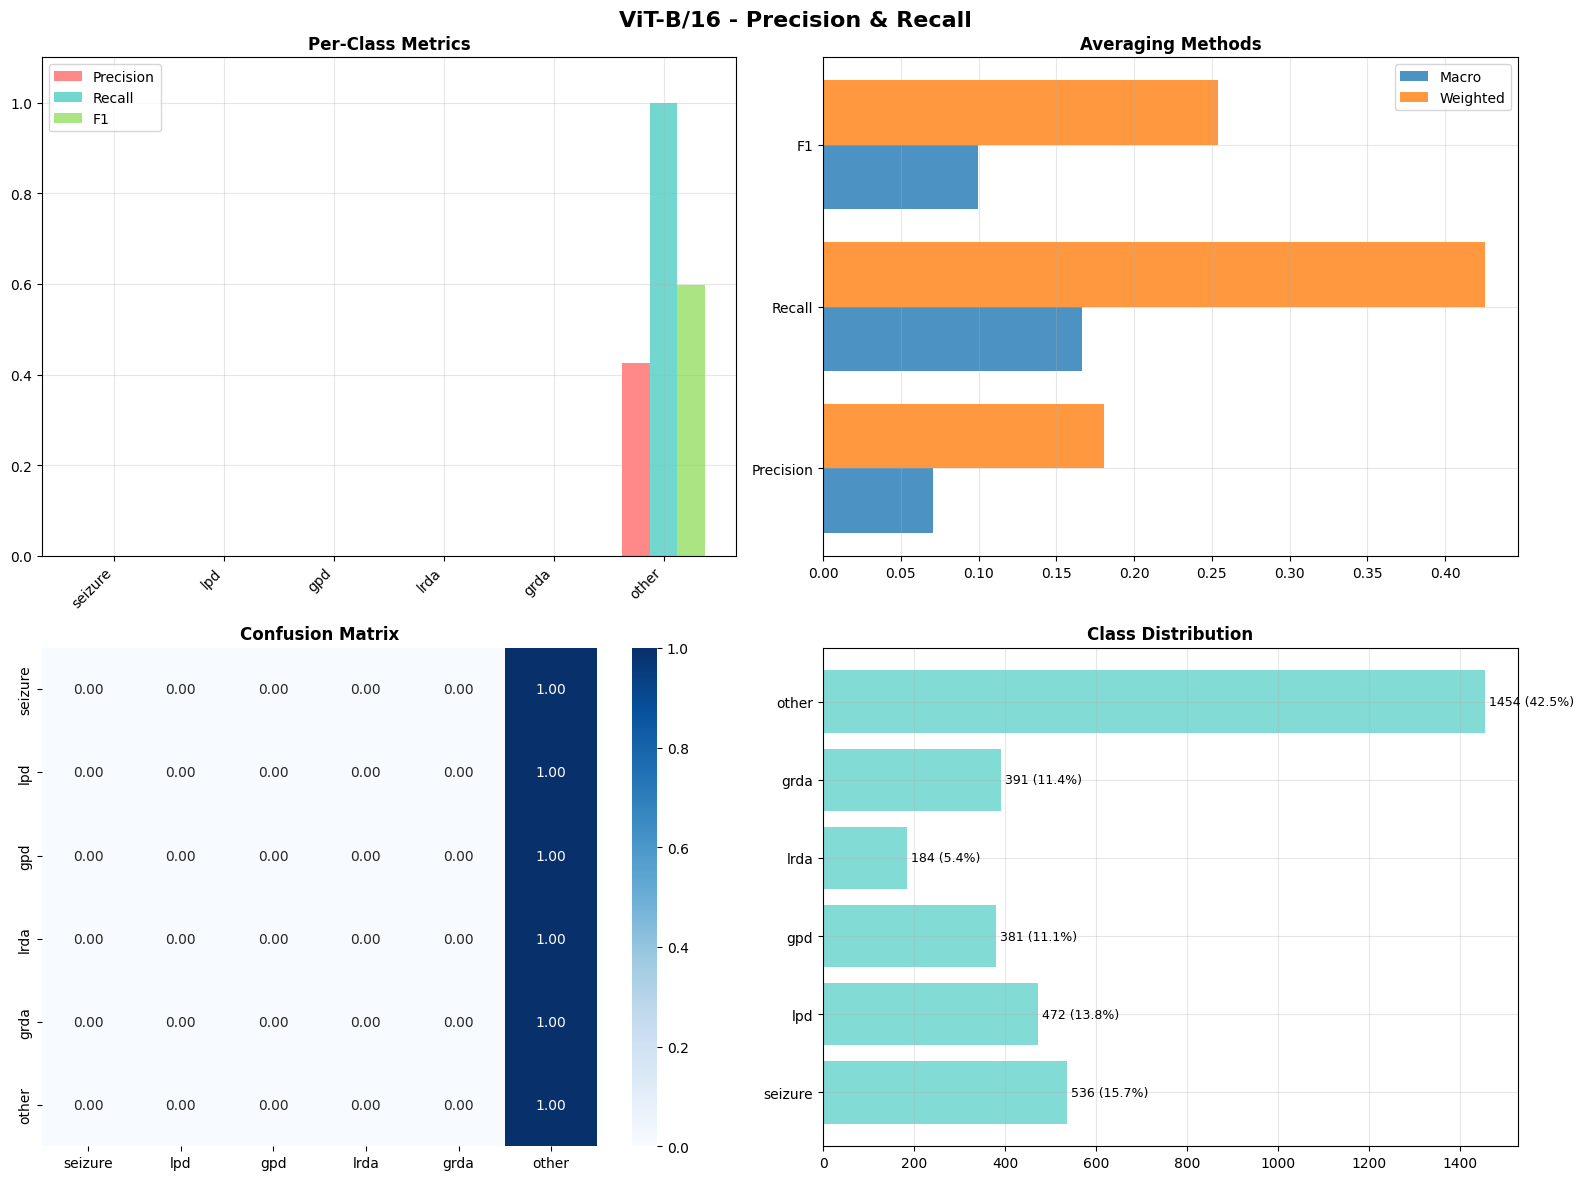


✅ COMPLETE!


In [28]:
# ============================================================================
# COMPLETE: DEFINE CLASS + LOAD + EVALUATE
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.models as models
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# ============================================================================
# STEP 1: DEFINE ViT CLASS
# ============================================================================

print("="*80)
print(" DEFINING ViT MODEL CLASS ".center(80, "="))
print("="*80)

class ViT_4Ch(nn.Module):
    """Vision Transformer for 4-channel EEG"""
    def __init__(self, n_classes=6, pretrained=True):
        super().__init__()
        if pretrained:
            weights = models.ViT_B_16_Weights.IMAGENET1K_V1
            self.model = models.vit_b_16(weights=weights)
        else:
            self.model = models.vit_b_16(weights=None)
        
        # Adapt first layer for 4 channels
        old_proj = self.model.conv_proj
        self.model.conv_proj = nn.Conv2d(4, old_proj.out_channels,
                                         kernel_size=old_proj.kernel_size,
                                         stride=old_proj.stride,
                                         padding=old_proj.padding)
        with torch.no_grad():
            self.model.conv_proj.weight[:, :3] = old_proj.weight
            self.model.conv_proj.weight[:, 3:] = old_proj.weight[:, :1] * 0.01
            if old_proj.bias is not None:
                self.model.conv_proj.bias = old_proj.bias
        
        # Replace classifier head
        n_features = self.model.heads.head.in_features
        self.model.heads.head = nn.Linear(n_features, n_classes)
    
    def forward(self, x):
        return self.model(x)

print("✅ ViT_4Ch class defined")
print("="*80 + "\n")

# ============================================================================
# STEP 2: LOAD MODEL
# ============================================================================

print("="*80)
print(" LOADING ViT MODEL ".center(80, "="))
print("="*80)

try:
    model_vit = ViT_4Ch(n_classes=6, pretrained=False)
    model_vit.load_state_dict(torch.load('vit_best.pth', map_location=device))
    model_vit = model_vit.to(device)
    model_vit.eval()
    print("✅ ViT model loaded from 'vit_best.pth'")
    
except FileNotFoundError:
    print("❌ File 'vit_best.pth' not found!")
    print("\nCari file .pth yang ada:")
    import os
    pth_files = [f for f in os.listdir('.') if f.endswith('.pth')]
    if pth_files:
        print("\nFile .pth tersedia:")
        for f in pth_files:
            print(f"  • {f}")
    model_vit = None
    
except Exception as e:
    print(f"❌ Error loading model: {e}")
    model_vit = None

print("="*80 + "\n")

# ============================================================================
# STEP 3: CREATE VALIDATION LOADER
# ============================================================================

if model_vit is not None:
    print("="*80)
    print(" CREATING VALIDATION LOADER ".center(80, "="))
    print("="*80)
    
    tr_idx, va_idx = folds[0]
    df_va = meta_use.iloc[va_idx]
    
    ds_va = SpecDataset(df_va, SPEC_DIR, y_soft, w_conf)
    dl_va = DataLoader(ds_va, batch_size=16, shuffle=False, 
                       num_workers=0, pin_memory=False)
    
    print(f"✅ Loader created: {len(ds_va)} samples")
    print("="*80 + "\n")
    
    # ============================================================================
    # STEP 4: EVALUATE
    # ============================================================================
    
    @torch.no_grad()
    def eval_pr(model, loader, classes):
        model.eval()
        all_preds, all_targets = [], []
        
        print("⏳ Evaluating ViT-B/16...")
        for x, y, w in loader:
            x = x.to(device)
            logits = model(x)
            all_preds.append(logits.argmax(1).cpu().numpy())
            all_targets.append(y.argmax(1).cpu().numpy())
        
        y_pred = np.concatenate(all_preds)
        y_true = np.concatenate(all_targets)
        
        # Calculate metrics
        prec = precision_score(y_true, y_pred, average=None, zero_division=0)
        rec = recall_score(y_true, y_pred, average=None, zero_division=0)
        f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
        
        prec_m = precision_score(y_true, y_pred, average='macro', zero_division=0)
        rec_m = recall_score(y_true, y_pred, average='macro', zero_division=0)
        f1_m = f1_score(y_true, y_pred, average='macro', zero_division=0)
        
        prec_w = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        rec_w = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1_w = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        
        support = np.bincount(y_true, minlength=len(classes))
        cm = confusion_matrix(y_true, y_pred)
        
        print("✅ Done!\n")
        
        # Print report
        print("="*85)
        print(" ViT-B/16 - PRECISION & RECALL ".center(85, "="))
        print("="*85)
        
        print("\n📊 OVERALL:")
        print("-"*85)
        print(f"{'Metric':<20s} {'Macro':>15s} {'Weighted':>15s}")
        print("-"*85)
        print(f"{'Precision':<20s} {prec_m:>15.4f} {prec_w:>15.4f}")
        print(f"{'Recall':<20s} {rec_m:>15.4f} {rec_w:>15.4f}")
        print(f"{'F1-Score':<20s} {f1_m:>15.4f} {f1_w:>15.4f}")
        print("-"*85)
        
        print("\n📋 PER-CLASS:")
        print("-"*85)
        print(f"{'Class':<15s} {'Precision':>12s} {'Recall':>12s} {'F1':>12s} {'Support':>10s}")
        print("-"*85)
        for i, cls in enumerate(classes):
            print(f"{cls:<15s} {prec[i]:>12.4f} {rec[i]:>12.4f} {f1[i]:>12.4f} {support[i]:>10d}")
        print("-"*85)
        
        # Analysis
        print("\n⚠️  ISSUES:")
        print("-"*85)
        
        low_prec = prec < 0.3
        low_rec = rec < 0.3
        
        if low_prec.any():
            print("🔴 Low Precision (<0.30):")
            for i in np.where(low_prec)[0]:
                print(f"   • {classes[i]}: {prec[i]:.4f}")
        
        if low_rec.any():
            print("\n🔴 Low Recall (<0.30):")
            for i in np.where(low_rec)[0]:
                print(f"   • {classes[i]}: {rec[i]:.4f}")
        
        if not (low_prec.any() or low_rec.any()):
            print("✅ No major issues")
        
        unique = len(np.unique(y_pred))
        print(f"\n📌 Predicts {unique}/{len(classes)} classes")
        
        if unique == 1:
            print(f"⚠️  CRITICAL: Only predicts '{classes[np.unique(y_pred)[0]]}'!")
        
        print("="*85 + "\n")
        
        # Plot
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Bar
        x = np.arange(len(classes))
        w = 0.25
        axes[0,0].bar(x-w, prec, w, label='Precision', alpha=0.8, color='#FF6B6B')
        axes[0,0].bar(x, rec, w, label='Recall', alpha=0.8, color='#4ECDC4')
        axes[0,0].bar(x+w, f1, w, label='F1', alpha=0.8, color='#95DE64')
        axes[0,0].set_xticks(x)
        axes[0,0].set_xticklabels(classes, rotation=45, ha='right')
        axes[0,0].legend()
        axes[0,0].set_title('Per-Class Metrics', fontweight='bold')
        axes[0,0].grid(alpha=0.3)
        axes[0,0].set_ylim(0, 1.1)
        
        # 2. Macro vs Weighted
        metrics = ['Precision', 'Recall', 'F1']
        macro = [prec_m, rec_m, f1_m]
        weighted = [prec_w, rec_w, f1_w]
        x_pos = np.arange(len(metrics))
        axes[0,1].barh(x_pos-0.2, macro, 0.4, label='Macro', alpha=0.8)
        axes[0,1].barh(x_pos+0.2, weighted, 0.4, label='Weighted', alpha=0.8)
        axes[0,1].set_yticks(x_pos)
        axes[0,1].set_yticklabels(metrics)
        axes[0,1].legend()
        axes[0,1].set_title('Averaging Methods', fontweight='bold')
        axes[0,1].grid(alpha=0.3)
        
        # 3. Confusion matrix
        cm_norm = cm / (cm.sum(1, keepdims=True) + 1e-9)
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                    xticklabels=classes, yticklabels=classes, ax=axes[1,0])
        axes[1,0].set_title('Confusion Matrix', fontweight='bold')
        
        # 4. Support
        axes[1,1].barh(classes, support, alpha=0.7, color='#4ECDC4')
        for i, val in enumerate(support):
            pct = 100 * val / support.sum()
            axes[1,1].text(val, i, f' {val} ({pct:.1f}%)', va='center', fontsize=9)
        axes[1,1].set_title('Class Distribution', fontweight='bold')
        axes[1,1].grid(alpha=0.3)
        
        plt.suptitle('ViT-B/16 - Precision & Recall', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('precision_recall_vit.png', dpi=300, bbox_inches='tight')
        print("💾 Saved: precision_recall_vit.png")
        plt.show()
    
    # RUN
    eval_pr(model_vit, dl_va, classes)
    print("\n✅ COMPLETE!")

============================ DEFINING MODEL CLASSES ============================
✅ All model classes defined

================================ LOADING MODELS ================================
✓ ResNet-50            - Loaded from resnet50_best.pth
✓ ResNet-101           - Loaded from resnet101_best.pth
✓ ResNet-152           - Loaded from resnet152_best.pth
✓ DenseNet-121         - Loaded from densenet121_best.pth
✓ DenseNet-169         - Loaded from densenet169_best.pth
✓ EfficientNet-B3      - Loaded from efficientnetb3_best.pth
✓ EfficientNet-B4      - Loaded from efficientnetb4_best.pth
✓ ViT-B/16             - Loaded from vit_best.pth
Loaded: 8/8 models

========================== CREATING VALIDATION LOADER ==========================
✅ Loader created: 3418 samples

============================ EVALUATING ALL MODELS =============================

⏳ Evaluating ResNet-50...
✅ ResNet-50: Precision=0.0709, Recall=0.1667, F1=0.0995
⏳ Evaluating ResNet-101...
✅ ResNet-101: Precision=0.1168

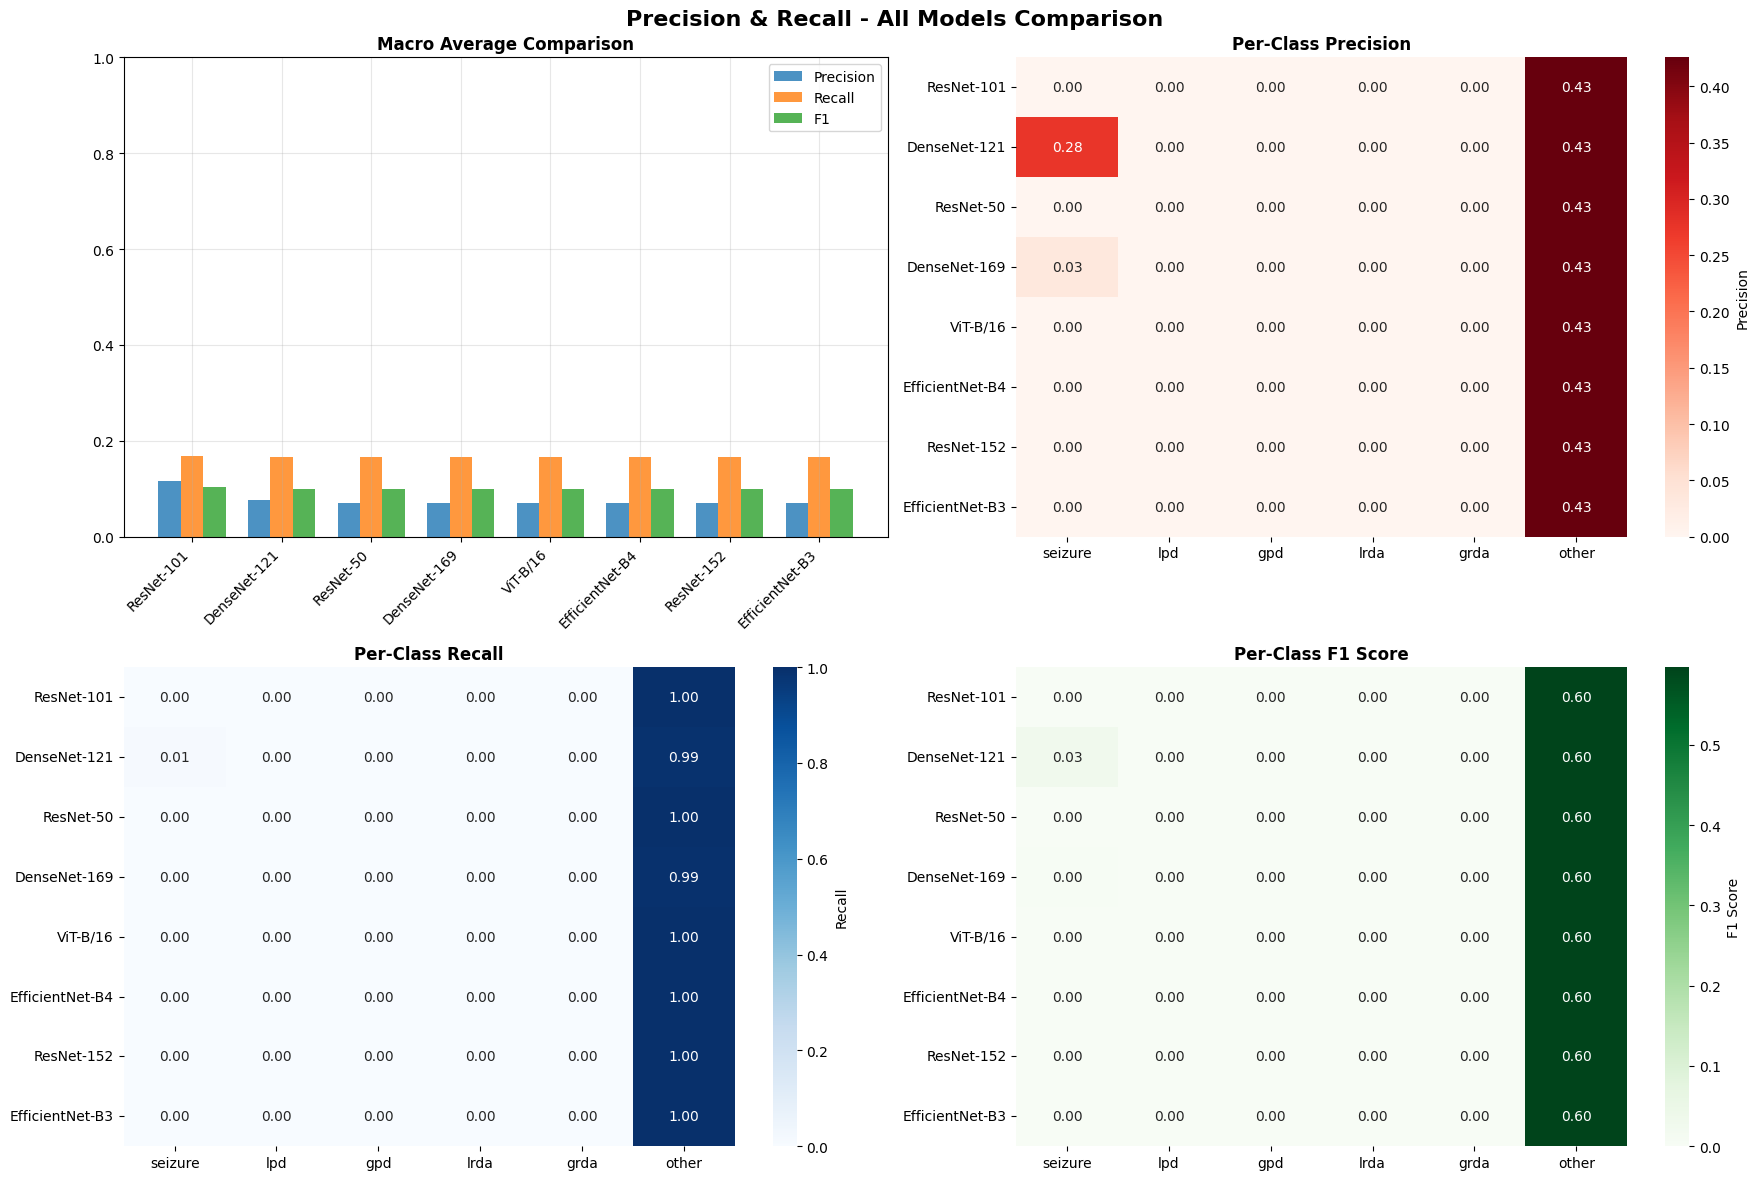


✅ CSV files saved:
   • precision_recall_comparison.csv
   • precision_per_class_all_models.csv
   • recall_per_class_all_models.csv
   • f1_per_class_all_models.csv

✅ COMPLETE! ALL MODELS EVALUATED!


In [29]:
# ============================================================================
# EVALUATE ALL 8 MODELS - PRECISION & RECALL
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.models as models
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# ============================================================================
# STEP 1: DEFINE ALL MODEL CLASSES
# ============================================================================

print("="*80)
print(" DEFINING MODEL CLASSES ".center(80, "="))
print("="*80)

class BaseModel4Ch(nn.Module):
    """Base class for 4-channel adaptation"""
    def adapt_first_conv(self, old_conv):
        new_conv = nn.Conv2d(
            in_channels=4,
            out_channels=old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=False if old_conv.bias is None else True
        )
        with torch.no_grad():
            new_conv.weight[:, :3] = old_conv.weight
            new_conv.weight[:, 3:] = old_conv.weight[:, :1] * 0.01
            if old_conv.bias is not None:
                new_conv.bias = old_conv.bias
        return new_conv

class ResNet50_4Ch(BaseModel4Ch):
    def __init__(self, n_classes=6, pretrained=False):
        super().__init__()
        self.model = models.resnet50(weights=None)
        self.model.conv1 = self.adapt_first_conv(self.model.conv1)
        self.model.fc = nn.Linear(self.model.fc.in_features, n_classes)
    def forward(self, x):
        return self.model(x)

class ResNet101_4Ch(BaseModel4Ch):
    def __init__(self, n_classes=6, pretrained=False):
        super().__init__()
        self.model = models.resnet101(weights=None)
        self.model.conv1 = self.adapt_first_conv(self.model.conv1)
        self.model.fc = nn.Linear(self.model.fc.in_features, n_classes)
    def forward(self, x):
        return self.model(x)

class ResNet152_4Ch(BaseModel4Ch):
    def __init__(self, n_classes=6, pretrained=False):
        super().__init__()
        self.model = models.resnet152(weights=None)
        self.model.conv1 = self.adapt_first_conv(self.model.conv1)
        self.model.fc = nn.Linear(self.model.fc.in_features, n_classes)
    def forward(self, x):
        return self.model(x)

class DenseNet121_4Ch(BaseModel4Ch):
    def __init__(self, n_classes=6, pretrained=False):
        super().__init__()
        self.model = models.densenet121(weights=None)
        self.model.features.conv0 = self.adapt_first_conv(self.model.features.conv0)
        self.model.classifier = nn.Linear(self.model.classifier.in_features, n_classes)
    def forward(self, x):
        return self.model(x)

class DenseNet169_4Ch(BaseModel4Ch):
    def __init__(self, n_classes=6, pretrained=False):
        super().__init__()
        self.model = models.densenet169(weights=None)
        self.model.features.conv0 = self.adapt_first_conv(self.model.features.conv0)
        self.model.classifier = nn.Linear(self.model.classifier.in_features, n_classes)
    def forward(self, x):
        return self.model(x)

class EfficientNetB3_4Ch(BaseModel4Ch):
    def __init__(self, n_classes=6, pretrained=False):
        super().__init__()
        self.model = models.efficientnet_b3(weights=None)
        self.model.features[0][0] = self.adapt_first_conv(self.model.features[0][0])
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, n_classes)
    def forward(self, x):
        return self.model(x)

class EfficientNetB4_4Ch(BaseModel4Ch):
    def __init__(self, n_classes=6, pretrained=False):
        super().__init__()
        self.model = models.efficientnet_b4(weights=None)
        self.model.features[0][0] = self.adapt_first_conv(self.model.features[0][0])
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, n_classes)
    def forward(self, x):
        return self.model(x)

class ViT_4Ch(BaseModel4Ch):
    def __init__(self, n_classes=6, pretrained=False):
        super().__init__()
        self.model = models.vit_b_16(weights=None)
        self.model.conv_proj = self.adapt_first_conv(self.model.conv_proj)
        self.model.heads.head = nn.Linear(self.model.heads.head.in_features, n_classes)
    def forward(self, x):
        return self.model(x)

print("✅ All model classes defined")
print("="*80 + "\n")

# ============================================================================
# STEP 2: LOAD ALL AVAILABLE MODELS
# ============================================================================

print("="*80)
print(" LOADING MODELS ".center(80, "="))
print("="*80)

MODEL_CONFIGS = {
    'ResNet-50': ('resnet50_best.pth', ResNet50_4Ch),
    'ResNet-101': ('resnet101_best.pth', ResNet101_4Ch),
    'ResNet-152': ('resnet152_best.pth', ResNet152_4Ch),
    'DenseNet-121': ('densenet121_best.pth', DenseNet121_4Ch),
    'DenseNet-169': ('densenet169_best.pth', DenseNet169_4Ch),
    'EfficientNet-B3': ('efficientnetb3_best.pth', EfficientNetB3_4Ch),
    'EfficientNet-B4': ('efficientnetb4_best.pth', EfficientNetB4_4Ch),
    'ViT-B/16': ('vit_best.pth', ViT_4Ch),
}

loaded_models = {}

for model_name, (pth_file, model_class) in MODEL_CONFIGS.items():
    try:
        model = model_class(n_classes=6, pretrained=False)
        model.load_state_dict(torch.load(pth_file, map_location=device))
        model = model.to(device)
        model.eval()
        loaded_models[model_name] = model
        print(f"✓ {model_name:20s} - Loaded from {pth_file}")
    except FileNotFoundError:
        print(f"✗ {model_name:20s} - File {pth_file} not found")
    except Exception as e:
        print(f"✗ {model_name:20s} - Error: {str(e)[:40]}")

print("="*80)
print(f"Loaded: {len(loaded_models)}/{len(MODEL_CONFIGS)} models")
print("="*80 + "\n")

if len(loaded_models) == 0:
    print("❌ No models loaded! Check if .pth files exist.")
else:
    # ============================================================================
    # STEP 3: CREATE VALIDATION LOADER
    # ============================================================================
    
    print("="*80)
    print(" CREATING VALIDATION LOADER ".center(80, "="))
    print("="*80)
    
    tr_idx, va_idx = folds[0]
    df_va = meta_use.iloc[va_idx]
    
    ds_va = SpecDataset(df_va, SPEC_DIR, y_soft, w_conf)
    dl_va = DataLoader(ds_va, batch_size=16, shuffle=False, 
                       num_workers=0, pin_memory=False)
    
    print(f"✅ Loader created: {len(ds_va)} samples")
    print("="*80 + "\n")
    
    # ============================================================================
    # STEP 4: EVALUATE ALL MODELS
    # ============================================================================
    
    @torch.no_grad()
    def eval_model(model, loader, classes, model_name):
        """Evaluate single model"""
        model.eval()
        all_preds, all_targets = [], []
        
        for x, y, w in loader:
            x = x.to(device)
            logits = model(x)
            all_preds.append(logits.argmax(1).cpu().numpy())
            all_targets.append(y.argmax(1).cpu().numpy())
        
        y_pred = np.concatenate(all_preds)
        y_true = np.concatenate(all_targets)
        
        # Metrics
        prec = precision_score(y_true, y_pred, average=None, zero_division=0)
        rec = recall_score(y_true, y_pred, average=None, zero_division=0)
        f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
        
        prec_m = precision_score(y_true, y_pred, average='macro', zero_division=0)
        rec_m = recall_score(y_true, y_pred, average='macro', zero_division=0)
        f1_m = f1_score(y_true, y_pred, average='macro', zero_division=0)
        
        support = np.bincount(y_true, minlength=len(classes))
        cm = confusion_matrix(y_true, y_pred)
        
        return {
            'precision_per_class': prec,
            'recall_per_class': rec,
            'f1_per_class': f1,
            'precision_macro': prec_m,
            'recall_macro': rec_m,
            'f1_macro': f1_m,
            'support': support,
            'cm': cm,
            'y_pred': y_pred,
            'y_true': y_true
        }
    
    # Evaluate all models
    all_results = {}
    
    print("="*80)
    print(" EVALUATING ALL MODELS ".center(80, "="))
    print("="*80 + "\n")
    
    for model_name, model in loaded_models.items():
        print(f"⏳ Evaluating {model_name}...")
        results = eval_model(model, dl_va, classes, model_name)
        all_results[model_name] = results
        print(f"✅ {model_name}: Precision={results['precision_macro']:.4f}, Recall={results['recall_macro']:.4f}, F1={results['f1_macro']:.4f}")
    
    print("\n" + "="*80)
    print(" EVALUATION COMPLETE ".center(80, "="))
    print("="*80 + "\n")
    
    # ============================================================================
    # STEP 5: PRINT COMPARISON TABLE
    # ============================================================================
    
    print("="*100)
    print(" PRECISION & RECALL COMPARISON ".center(100, "="))
    print("="*100)
    
    comparison_data = {
        'Model': [],
        'Precision (Macro)': [],
        'Recall (Macro)': [],
        'F1 (Macro)': []
    }
    
    for model_name, results in all_results.items():
        comparison_data['Model'].append(model_name)
        comparison_data['Precision (Macro)'].append(results['precision_macro'])
        comparison_data['Recall (Macro)'].append(results['recall_macro'])
        comparison_data['F1 (Macro)'].append(results['f1_macro'])
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('F1 (Macro)', ascending=False)
    
    print("\n", comparison_df.to_string(index=False))
    
    print("\n" + "="*100)
    print(f"🏆 BEST MODEL: {comparison_df.iloc[0]['Model']}")
    print(f"   Precision: {comparison_df.iloc[0]['Precision (Macro)']:.4f}")
    print(f"   Recall:    {comparison_df.iloc[0]['Recall (Macro)']:.4f}")
    print(f"   F1:        {comparison_df.iloc[0]['F1 (Macro)']:.4f}")
    print("="*100 + "\n")
    
    # ============================================================================
    # STEP 6: PER-CLASS COMPARISON
    # ============================================================================
    
    print("="*100)
    print(" PER-CLASS PRECISION ".center(100, "="))
    print("="*100)
    
    prec_data = {'Class': classes}
    for model_name, results in all_results.items():
        prec_data[model_name] = results['precision_per_class']
    
    prec_df = pd.DataFrame(prec_data)
    print("\n", prec_df.to_string(index=False))
    
    print("\n" + "="*100)
    print(" PER-CLASS RECALL ".center(100, "="))
    print("="*100)
    
    rec_data = {'Class': classes}
    for model_name, results in all_results.items():
        rec_data[model_name] = results['recall_per_class']
    
    rec_df = pd.DataFrame(rec_data)
    print("\n", rec_df.to_string(index=False))
    
    # ============================================================================
    # STEP 7: VISUALIZATION
    # ============================================================================
    
    print("\n" + "="*80)
    print(" CREATING VISUALIZATIONS ".center(80, "="))
    print("="*80 + "\n")
    
    # Plot 1: Overall comparison
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Bar chart
    ax = axes[0, 0]
    x = np.arange(len(comparison_df))
    width = 0.25
    ax.bar(x - width, comparison_df['Precision (Macro)'], width, label='Precision', alpha=0.8)
    ax.bar(x, comparison_df['Recall (Macro)'], width, label='Recall', alpha=0.8)
    ax.bar(x + width, comparison_df['F1 (Macro)'], width, label='F1', alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
    ax.legend()
    ax.set_title('Macro Average Comparison', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.set_ylim(0, 1)
    
    # Precision heatmap
    ax = axes[0, 1]
    prec_matrix = prec_df.iloc[:, 1:].T
    sns.heatmap(prec_matrix, annot=True, fmt='.2f', cmap='Reds',
                xticklabels=classes, yticklabels=comparison_df['Model'],
                ax=ax, cbar_kws={'label': 'Precision'})
    ax.set_title('Per-Class Precision', fontsize=12, fontweight='bold')
    
    # Recall heatmap
    ax = axes[1, 0]
    rec_matrix = rec_df.iloc[:, 1:].T
    sns.heatmap(rec_matrix, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes, yticklabels=comparison_df['Model'],
                ax=ax, cbar_kws={'label': 'Recall'})
    ax.set_title('Per-Class Recall', fontsize=12, fontweight='bold')
    
    # F1 heatmap
    ax = axes[1, 1]
    f1_data = {'Class': classes}
    for model_name, results in all_results.items():
        f1_data[model_name] = results['f1_per_class']
    f1_df = pd.DataFrame(f1_data)
    f1_matrix = f1_df.iloc[:, 1:].T
    sns.heatmap(f1_matrix, annot=True, fmt='.2f', cmap='Greens',
                xticklabels=classes, yticklabels=comparison_df['Model'],
                ax=ax, cbar_kws={'label': 'F1 Score'})
    ax.set_title('Per-Class F1 Score', fontsize=12, fontweight='bold')
    
    plt.suptitle('Precision & Recall - All Models Comparison', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('all_models_precision_recall.png', dpi=300, bbox_inches='tight')
    print("💾 Saved: all_models_precision_recall.png")
    plt.show()
    
    # Save CSVs
    comparison_df.to_csv('precision_recall_comparison.csv', index=False)
    prec_df.to_csv('precision_per_class_all_models.csv', index=False)
    rec_df.to_csv('recall_per_class_all_models.csv', index=False)
    f1_df.to_csv('f1_per_class_all_models.csv', index=False)
    
    print("\n✅ CSV files saved:")
    print("   • precision_recall_comparison.csv")
    print("   • precision_per_class_all_models.csv")
    print("   • recall_per_class_all_models.csv")
    print("   • f1_per_class_all_models.csv")
    
    print("\n" + "="*80)
    print("✅ COMPLETE! ALL MODELS EVALUATED!")
    print("="*80)

============================= SOFT LABEL ANALYSIS ==============================

📊 ANALYZING SOFT LABELS...

1️⃣  UNCERTAINTY ANALYSIS:
--------------------------------------------------------------------------------
Average entropy:        0.3354
Max possible entropy:   1.7918
Normalized uncertainty: 18.72%
High uncertainty (>50%): 2214 samples (13.0%)
--------------------------------------------------------------------------------

2️⃣  CONFIDENCE ANALYSIS:
--------------------------------------------------------------------------------
Average max probability: 0.8428
Median max probability:  1.0000

Confidence distribution:
  Very confident (>0.8):  10913 ( 63.9%)
  Confident (0.6-0.8):     3151 ( 18.4%)
  Uncertain (0.4-0.6):     2498 ( 14.6%)
  Very uncertain (<0.4):    527 (  3.1%)
--------------------------------------------------------------------------------

3️⃣  MULTI-LABEL POTENTIAL:
--------------------------------------------------------------------------------
Average 2

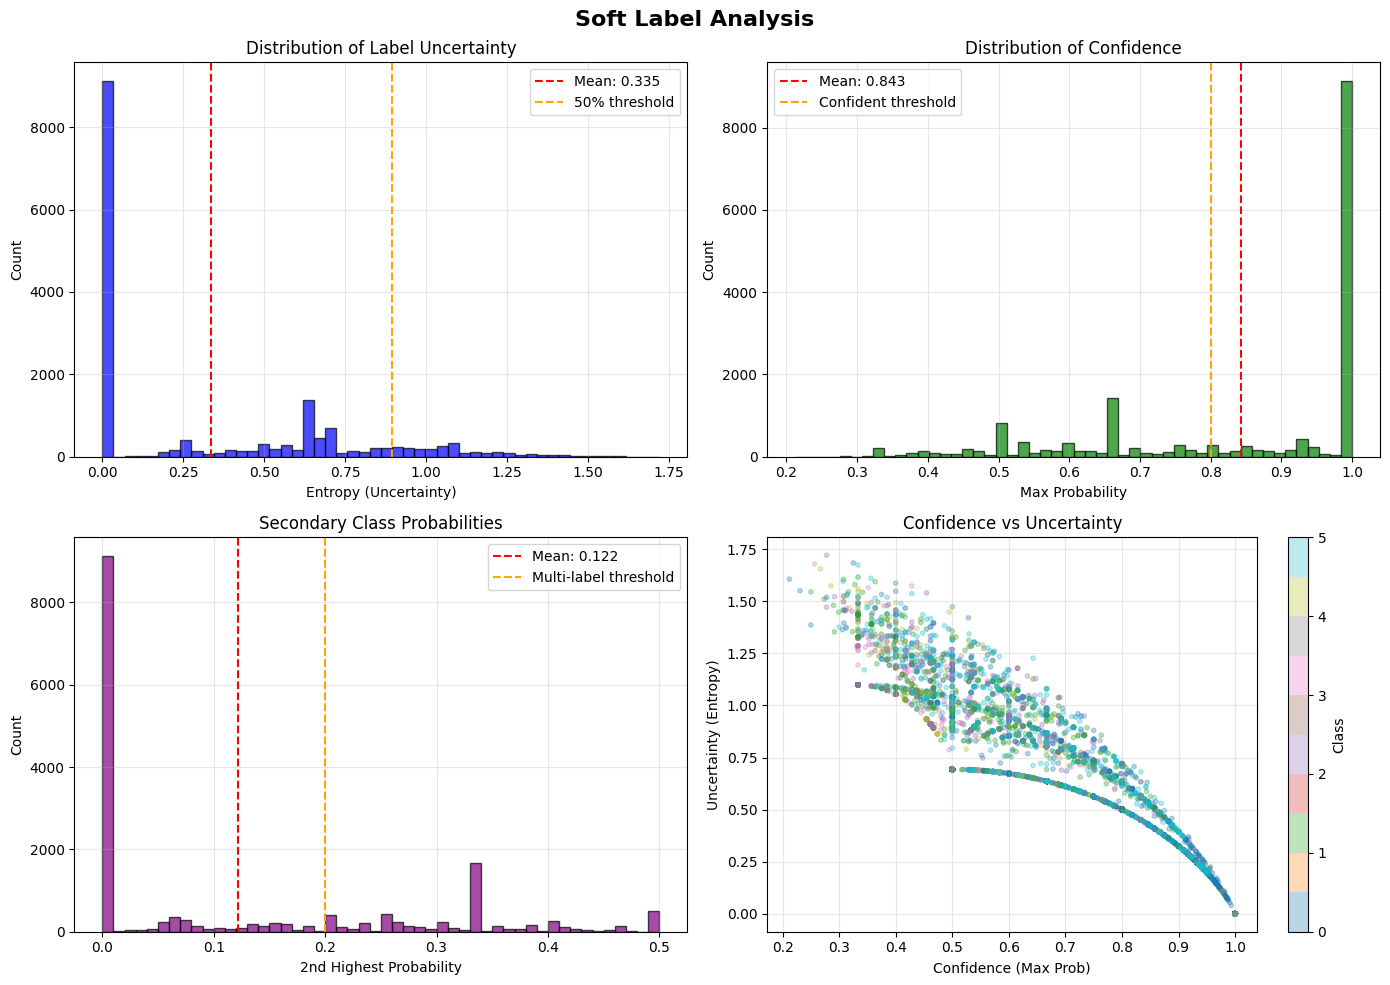


================================ RECOMMENDATION ================================

📋 ANALYSIS RESULTS:
  • Average confidence:     84.28%
  • High uncertainty rate:  12.96%
  • Multi-label potential:  29.93%

💡 RECOMMENDATION:
--------------------------------------------------------------------------------
✅ USE SOFT LABELS (CURRENT APPROACH)

Reason:
  • Multi-label potential (29.93% with strong 2nd class)

Benefit:
  • Preserves label uncertainty
  • Better for ambiguous cases
  • Captures rater disagreement

⚠️  BUT: Your current issue is CLASS IMBALANCE, not soft labels!

📝 TO FIX:
```python
# Keep soft labels BUT use:
1. Hybrid oversampling (manual + weighted)
2. Focal loss adapted for soft labels
3. Two-stage training
```

✅ ANALYSIS COMPLETE!


In [30]:
# ============================================================================
# ANALISIS: SOFT LABEL vs HARD LABEL - MANA YANG LEBIH BAIK?
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt

print("="*80)
print(" SOFT LABEL ANALYSIS ".center(80, "="))
print("="*80)

# Ambil sample dari y_soft
print("\n📊 ANALYZING SOFT LABELS...\n")

# 1. Check entropy (uncertainty)
def entropy(probs):
    """Calculate entropy of probability distribution"""
    probs = probs + 1e-10  # Avoid log(0)
    return -np.sum(probs * np.log(probs), axis=1)

entropies = entropy(y_soft)
max_entropy = np.log(6)  # Max entropy for 6 classes

print("1️⃣  UNCERTAINTY ANALYSIS:")
print("-"*80)
print(f"Average entropy:        {entropies.mean():.4f}")
print(f"Max possible entropy:   {max_entropy:.4f}")
print(f"Normalized uncertainty: {entropies.mean()/max_entropy:.2%}")
print(f"High uncertainty (>50%): {(entropies > max_entropy*0.5).sum()} samples ({100*(entropies > max_entropy*0.5).sum()/len(entropies):.1f}%)")
print("-"*80)

# 2. Check confidence of dominant class
max_probs = y_soft.max(axis=1)

print("\n2️⃣  CONFIDENCE ANALYSIS:")
print("-"*80)
print(f"Average max probability: {max_probs.mean():.4f}")
print(f"Median max probability:  {np.median(max_probs):.4f}")
print(f"\nConfidence distribution:")
print(f"  Very confident (>0.8):  {(max_probs > 0.8).sum():5d} ({100*(max_probs > 0.8).sum()/len(max_probs):5.1f}%)")
print(f"  Confident (0.6-0.8):    {((max_probs > 0.6) & (max_probs <= 0.8)).sum():5d} ({100*((max_probs > 0.6) & (max_probs <= 0.8)).sum()/len(max_probs):5.1f}%)")
print(f"  Uncertain (0.4-0.6):    {((max_probs > 0.4) & (max_probs <= 0.6)).sum():5d} ({100*((max_probs > 0.4) & (max_probs <= 0.6)).sum()/len(max_probs):5.1f}%)")
print(f"  Very uncertain (<0.4):  {(max_probs <= 0.4).sum():5d} ({100*(max_probs <= 0.4).sum()/len(max_probs):5.1f}%)")
print("-"*80)

# 3. Check secondary classes (multi-label potential)
second_max_probs = np.partition(y_soft, -2, axis=1)[:, -2]

print("\n3️⃣  MULTI-LABEL POTENTIAL:")
print("-"*80)
print(f"Average 2nd highest prob: {second_max_probs.mean():.4f}")
print(f"Samples with 2nd > 0.3:   {(second_max_probs > 0.3).sum():5d} ({100*(second_max_probs > 0.3).sum()/len(second_max_probs):5.1f}%)")
print(f"Samples with 2nd > 0.2:   {(second_max_probs > 0.2).sum():5d} ({100*(second_max_probs > 0.2).sum()/len(second_max_probs):5.1f}%)")
print("-"*80)

# 4. Per-class confidence
print("\n4️⃣  PER-CLASS CONFIDENCE:")
print("-"*80)
print(f"{'Class':<15s} {'Avg Confidence':>18s} {'Samples':>10s}")
print("-"*80)

y_hard = y_soft.argmax(axis=1)
for i, cls in enumerate(classes):
    mask = y_hard == i
    if mask.sum() > 0:
        avg_conf = y_soft[mask, i].mean()
        n_samples = mask.sum()
        print(f"{cls:<15s} {avg_conf:>18.4f} {n_samples:>10d}")
print("-"*80)

# ============================================================================
# VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Entropy distribution
ax = axes[0, 0]
ax.hist(entropies, bins=50, alpha=0.7, color='blue', edgecolor='black')
ax.axvline(entropies.mean(), color='red', linestyle='--', label=f'Mean: {entropies.mean():.3f}')
ax.axvline(max_entropy*0.5, color='orange', linestyle='--', label='50% threshold')
ax.set_xlabel('Entropy (Uncertainty)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Label Uncertainty')
ax.legend()
ax.grid(alpha=0.3)

# 2. Max probability distribution
ax = axes[0, 1]
ax.hist(max_probs, bins=50, alpha=0.7, color='green', edgecolor='black')
ax.axvline(max_probs.mean(), color='red', linestyle='--', label=f'Mean: {max_probs.mean():.3f}')
ax.axvline(0.8, color='orange', linestyle='--', label='Confident threshold')
ax.set_xlabel('Max Probability')
ax.set_ylabel('Count')
ax.set_title('Distribution of Confidence')
ax.legend()
ax.grid(alpha=0.3)

# 3. Second max probability
ax = axes[1, 0]
ax.hist(second_max_probs, bins=50, alpha=0.7, color='purple', edgecolor='black')
ax.axvline(second_max_probs.mean(), color='red', linestyle='--', label=f'Mean: {second_max_probs.mean():.3f}')
ax.axvline(0.2, color='orange', linestyle='--', label='Multi-label threshold')
ax.set_xlabel('2nd Highest Probability')
ax.set_ylabel('Count')
ax.set_title('Secondary Class Probabilities')
ax.legend()
ax.grid(alpha=0.3)

# 4. Confidence vs Uncertainty scatter
ax = axes[1, 1]
scatter = ax.scatter(max_probs, entropies, alpha=0.3, c=y_hard, cmap='tab10', s=10)
ax.set_xlabel('Confidence (Max Prob)')
ax.set_ylabel('Uncertainty (Entropy)')
ax.set_title('Confidence vs Uncertainty')
ax.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Class')

plt.suptitle('Soft Label Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('soft_label_analysis.png', dpi=300, bbox_inches='tight')
print("\n💾 Saved: soft_label_analysis.png")
plt.show()

# ============================================================================
# RECOMMENDATION
# ============================================================================

print("\n" + "="*80)
print(" RECOMMENDATION ".center(80, "="))
print("="*80)

avg_confidence = max_probs.mean()
high_uncertainty_pct = (entropies > max_entropy*0.5).sum() / len(entropies)
multi_label_pct = (second_max_probs > 0.2).sum() / len(second_max_probs)

print("\n📋 ANALYSIS RESULTS:")
print(f"  • Average confidence:     {avg_confidence:.2%}")
print(f"  • High uncertainty rate:  {high_uncertainty_pct:.2%}")
print(f"  • Multi-label potential:  {multi_label_pct:.2%}")

print("\n💡 RECOMMENDATION:")
print("-"*80)

if avg_confidence > 0.8 and high_uncertainty_pct < 0.1:
    print("✅ USE HARD LABELS")
    print("\nReason:")
    print("  • Labels are very confident (>{:.0%})".format(avg_confidence))
    print("  • Low uncertainty (<{:.0%} ambiguous)".format(high_uncertainty_pct))
    print("  • Soft labels add unnecessary complexity")
    print("\nBenefit:")
    print("  • Simpler training (use CrossEntropyLoss)")
    print("  • Faster convergence")
    print("  • Better with focal loss")
    
    print("\n📝 TO IMPLEMENT:")
    print("```python")
    print("# Convert to hard labels")
    print("y_hard = y_soft.argmax(axis=1)")
    print("")
    print("# Use CrossEntropyLoss + Focal Loss")
    print("criterion = FocalLoss(alpha=class_weights, gamma=3.0)")
    print("loss = criterion(logits, y_hard)  # Much simpler!")
    print("```")

elif avg_confidence < 0.6 or high_uncertainty_pct > 0.3 or multi_label_pct > 0.2:
    print("✅ USE SOFT LABELS (CURRENT APPROACH)")
    print("\nReason:")
    if avg_confidence < 0.6:
        print(f"  • Low average confidence ({avg_confidence:.2%})")
    if high_uncertainty_pct > 0.3:
        print(f"  • High uncertainty ({high_uncertainty_pct:.2%} ambiguous samples)")
    if multi_label_pct > 0.2:
        print(f"  • Multi-label potential ({multi_label_pct:.2%} with strong 2nd class)")
    
    print("\nBenefit:")
    print("  • Preserves label uncertainty")
    print("  • Better for ambiguous cases")
    print("  • Captures rater disagreement")
    
    print("\n⚠️  BUT: Your current issue is CLASS IMBALANCE, not soft labels!")
    print("\n📝 TO FIX:")
    print("```python")
    print("# Keep soft labels BUT use:")
    print("1. Hybrid oversampling (manual + weighted)")
    print("2. Focal loss adapted for soft labels")
    print("3. Two-stage training")
    print("```")

else:
    print("🤔 BORDERLINE CASE")
    print("\nRecommendation:")
    print("  • Try BOTH approaches and compare!")
    print("  • Soft labels: {:.2%} average confidence".format(avg_confidence))
    print("  • Could benefit from either approach")
    
    print("\n📝 EXPERIMENT:")
    print("```python")
    print("# Approach 1: Keep soft labels + better training")
    print("# Approach 2: Convert to hard labels + focal loss")
    print("# Compare which works better!")
    print("```")

print("="*80)
print("\n✅ ANALYSIS COMPLETE!")